# GDS to Meep

[Gmeep Github](https://github.com/gdsfactory/gdsfactory/tree/main/gdsfactory/simulation/gmeep)

It is often useful to simulate photonic devices before manufacturing them so that you have some idea of their performance. GDSFactory has a Meep plugin, Gmeep, that can be used to simulate devices using the finite-difference time-domain algorithm (FDTD).

There are several functions within Gmeep that can be used to take a component and turn it into a Meep geometry or simulation. This means that you can take any component, either from GDSFactory or from a GDS file (see the component_from_gds notebook), and easily turn it into a Meep geometry. The two most general functions are `get_simulation` and `get_meep_geometry_from_component` (contained within gmeep.get_simulation.py). There are other more specific functions to get simulations for a grating coupler with a fiber connected to it, as well as for a far-field simulation for a grating coupler. However, the first two will suffice in this tutorial. Below is some example code showing the use of the functions.

* Description of what the functions do (more about how gds works and maybe give a little bit of detail about how the functions are coded)
* what kwargs they accept
* pitfalls to avoid



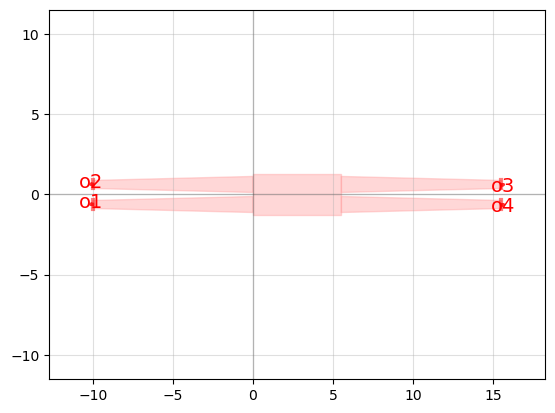

TypeError: Vector3.__init__() takes from 1 to 4 positional arguments but 8 were given

In [3]:
# Code showing examples for the functions in get_simulation


import gdsfactory as gf
import meep as mp
import tidy3d
# Import the functions
# They are both in gmeep.get_simulation.py
from gdsfactory.simulation.gmeep.get_simulation import get_simulation, get_meep_geometry_from_component

c = gf.components.mmi2x2()
c.plot()
get_meep_geometry_from_component(c)

# get_simulation implementation example
sim = get_simulation(component=c,
    resolution=20,
    )
sim['sim'].sources[0].size.y = 5
sim['sim'].cell_size.y = 8
sim['sim'].cell_size.x = 32
sim = mp.Simulation(sim)

from gdsfactory.simulation.gmeep import write_sparameters_meep

### Finding S-parameters through gmeep

There are several functions in GDSFactory that allow you to find the S-parameters (scattering parameters) of a given component. S-parameters are useful as they tell you how much light is coming in and out of each of the component's port. The most general function for this purpose in Gmeep is `write_sparameters_meep`. To use this function, you specify a GDSFactory component, the frequencies you want to test it at, if you would like the simulation to be in 3D, and the margins the simulation needs to take into account. This is not a comprehensive list and is only intended to give a general idea of how the function is used.

Another useful kwarg is "run". By setting this to `False`, the function plots the simulation geometry instead of running it. This allows you to make sure the geometry is correct before you waste time simulating it. This is especially important when running the simulation in 3D, as sometimes you may accidentally only have a 2D region, so trying to simulate in 3D with lead to errors.

The function returns a dictionary of s-parameters. The keys take the form of `"o1@0,o2@0"`, where the first part of the key refers to what port the light is coming from and the second refers to where it is going. For however many ports you have in your component, there will be a key corresponding to the s-parameter from that port to every other port.

Since the relationship between some ports can be the same (i.e. the component may be symmetric), port symmetries can be specified as a keyword argument (kwarg) (`port_symmetries`). This argument takes a dictionary where you specify one s-parameter as the key, and assign as its values the other s-parameters that correspond to it. For example, if you had a 1x2 splitter, where the 2 output ports were symmetric and labeled ports 2 and 3, then you could assign:

```port_symmetries = {"o2@0,o1@0": ["o3@0,o1@0"]}```

 so that the s-parameter for port 2 to 1 will be computed, but the one for port 3 to 1 will not be and will be written with the s-parameter for port 2 to 1. Thus, you save on computation time.

In addition to this general function, Gmeep also has two functions that can be used to write the s-parameters using parallel processing. These are `write_sparamters_meep_mpi` and `write_sparameters_meep_batch`. `write_sparamters_meep_mpi` has you specify how many cores you want to use as a kwarg. `write_sparameters_meep_batch` takes it a step further and runs multiple simulations in parallel, instead of just one. So, you must specify the number of cores per run in addition to the total number of cores to use.

`write_sparameters_grating` is a more specific instance that can be used to find the s-parameters for a grating coupler with an attached fiber. To plot the set up of this, you can pass in the argument `plot=True`. There is also the option of writing the s-parameters for a grating coupler in parallel or in batches, with `write_sparameters_grating_mpi` and `write_sparameters_grating_batch`. Like the general s-parameter functions above, more kwargs are necessary to define them.

### Adjoint solver in GDSFactory

The documentation on this in gdsfactory is slightly better and they have some example code that looks like it functions

However, it is still rather confined in GDSFactory, the functions there take a bit of finessing in order to have the same flexibility. Two functions in meep_adjoint_optimization.py in the GMeep library are used to create an `OptimizationProblem` object and then used to run the optimization. They are `get_meep_adjoint_optimizer` and `run_meep_adjoint_optimizer`, respectively.

`get_meep_adjoint_optimizer` takes in a gdsfactory component along with a host of other parameters necessary to set up the optimization. This includes the design region (which usually will overlay some part of the given component), the objective function specifying what you are actually optimizing for, and the design variables that you are initializing the design region to.

After calling this function, `run_meep_adjoint_optimizer` can be called to run the adjoint optimization with Meep. This function is where you specify, among other things, the bounds of optimization and what algorithm you are using for optimization.

* **EXAMPLE**